In [40]:
import sys
sys.path.append('..')
from somegrad import Tensor
import somegrad.functional as F
from somegrad.nn import Linear, BatchNorm1d, Tanh

In [41]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [42]:
words = open('names.txt', 'r').read().splitlines()

In [43]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [44]:
def build_dataset(words, block_size):
    xs, ys = [], []

    for w in words:
        context = [0] * block_size
        
        for ch in w + '.':
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)

            context = context[1:] + [ix] # crop and append
    
    xs = Tensor(xs) 
    ys = Tensor(ys)
    return xs, ys

random.seed(42)
random.shuffle(words)

n = len(words)
n1 = int(0.8 * n)
n2 = int(0.9 * n)

train_words = words[:n1]      # 80%
dev_words   = words[n1:n2]    # 10%
test_words  = words[n2:]      # 10%

print(f"Split sizes: Train: {len(train_words)}, Dev: {len(dev_words)}, Test: {len(test_words)}")

block_size = 3

# create datasets
Xtr, Ytr   = build_dataset(train_words, block_size)
Xdev, Ydev = build_dataset(dev_words, block_size)
Xte, Yte   = build_dataset(test_words, block_size)

Split sizes: Train: 25626, Dev: 3203, Test: 3204


In [45]:
np.random.seed(42)

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

C = Tensor(np.random.randn(27, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, 27, bias=False), BatchNorm1d(27),
]

# last layer: make less confident
layers[-1].gamma *= 0.1

# all other layers: apply gain
for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.data.size for p in parameters)) # number of parameters in total

47024


In [46]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = np.random.randint(0, Xtr.data.shape[0], (32,))
    Xb, Yb = Xtr.data[ix], Ytr.data[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.reshape(-1, block_size * n_embd) # reshape the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = np.zeros_like(p.data)
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.data.item():.4f}')
    lossi.append(loss.log().data.item())
    ud.append([((lr*p.grad).std() / p.std()).log().data.item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2973


layer 2 (      Tanh): mean -0.01, std 0.64, saturated: 3.03%
layer 5 (      Tanh): mean +0.01, std 0.65, saturated: 2.97%
layer 8 (      Tanh): mean +0.01, std 0.65, saturated: 2.69%
layer 11 (      Tanh): mean +0.01, std 0.65, saturated: 2.47%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 1.53%


Text(0.5, 1.0, 'activation distribution')

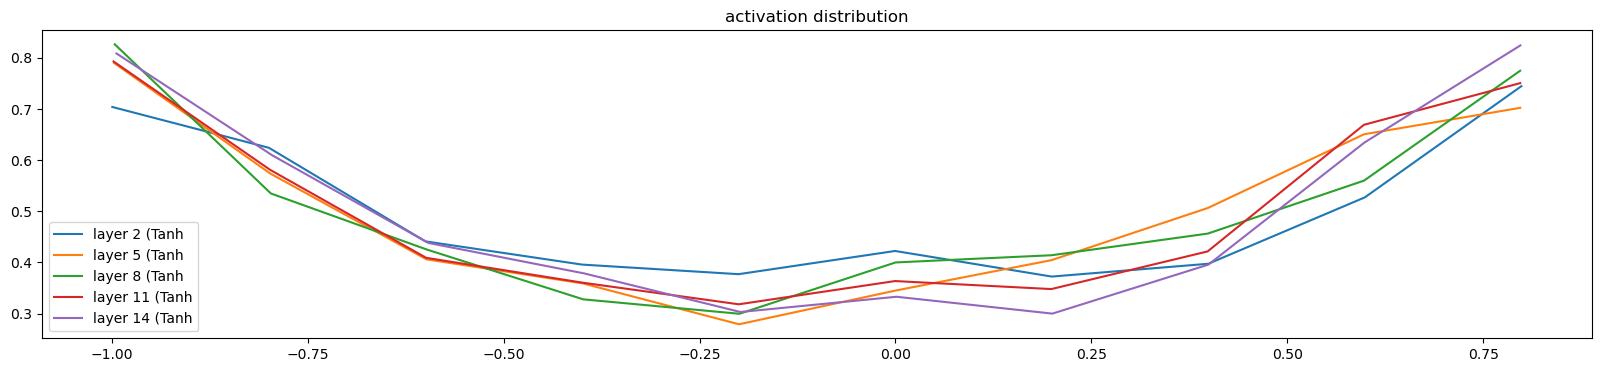

In [47]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (abs(t) > 0.97).float().mean()*100))
    hy, hx = F.histogram(t, density=True)
    plt.plot(hx[:-1].data, hy.data)
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.001205e-03
layer 5 (      Tanh): mean -0.000000, std 2.426616e-03
layer 8 (      Tanh): mean +0.000000, std 2.224863e-03
layer 11 (      Tanh): mean -0.000000, std 1.994465e-03
layer 14 (      Tanh): mean -0.000000, std 1.947821e-03


Text(0.5, 1.0, 'gradient distribution')

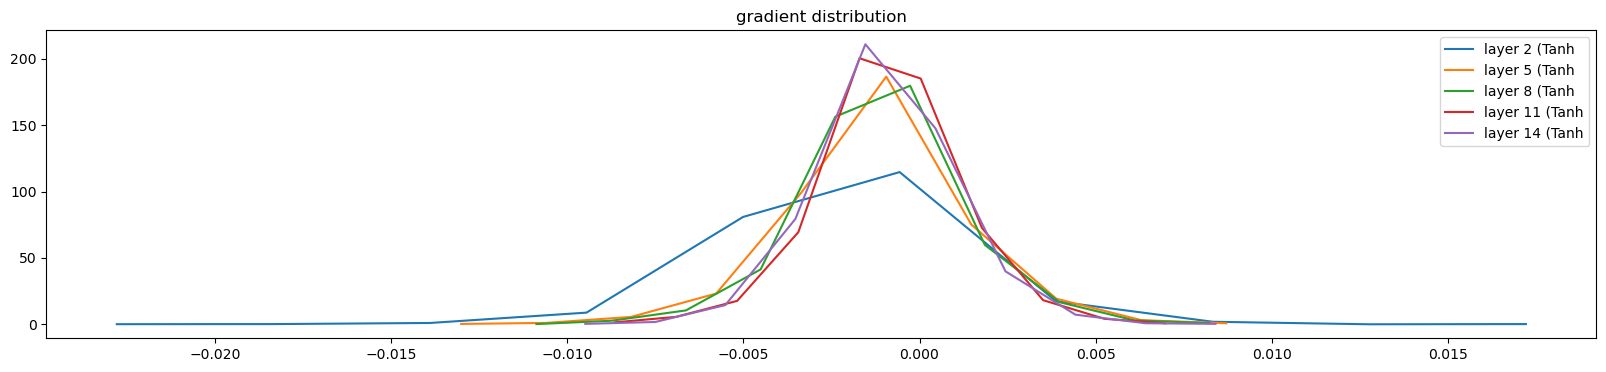

In [48]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = F.histogram(t, density=True)
    plt.plot(hx[:-1].data, hy.data)
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.205198e-02 | grad:data ratio 1.216796e-02
weight  (30, 100) | mean +0.000325 | std 1.069751e-02 | grad:data ratio 5.836420e-02
weight (100, 100) | mean +0.000017 | std 7.359340e-03 | grad:data ratio 7.149925e-02
weight (100, 100) | mean +0.000080 | std 6.938901e-03 | grad:data ratio 6.771099e-02
weight (100, 100) | mean +0.000096 | std 6.513614e-03 | grad:data ratio 6.433363e-02
weight (100, 100) | mean -0.000159 | std 5.573860e-03 | grad:data ratio 5.483690e-02
weight  (100, 27) | mean -0.000053 | std 1.152161e-02 | grad:data ratio 1.123107e-01


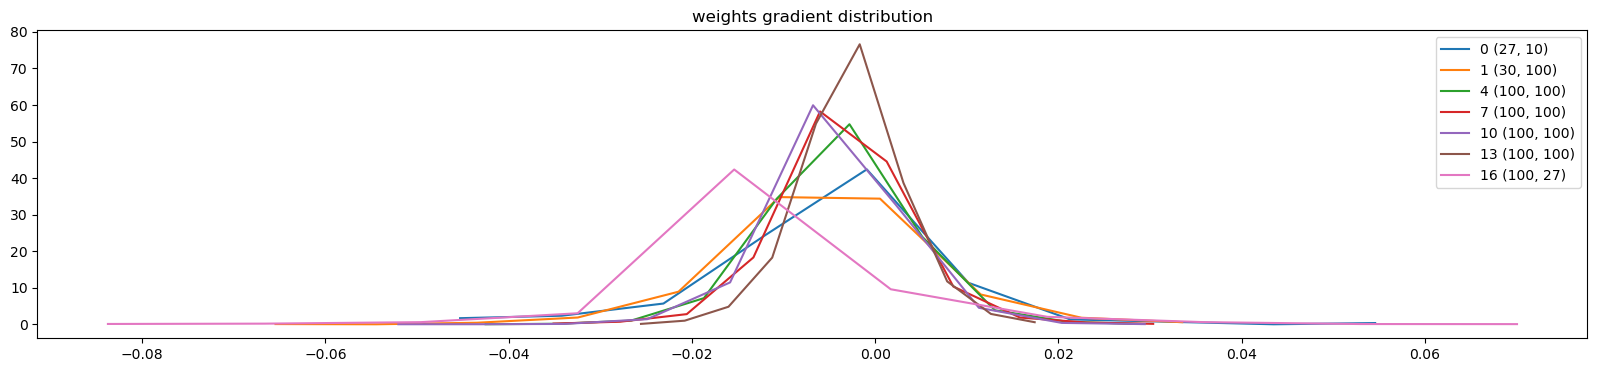

In [49]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.data.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.data.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = F.histogram(t, density=True)
    plt.plot(hx[:-1].data, hy.data)
    legends.append(f'{i} {tuple(p.data.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

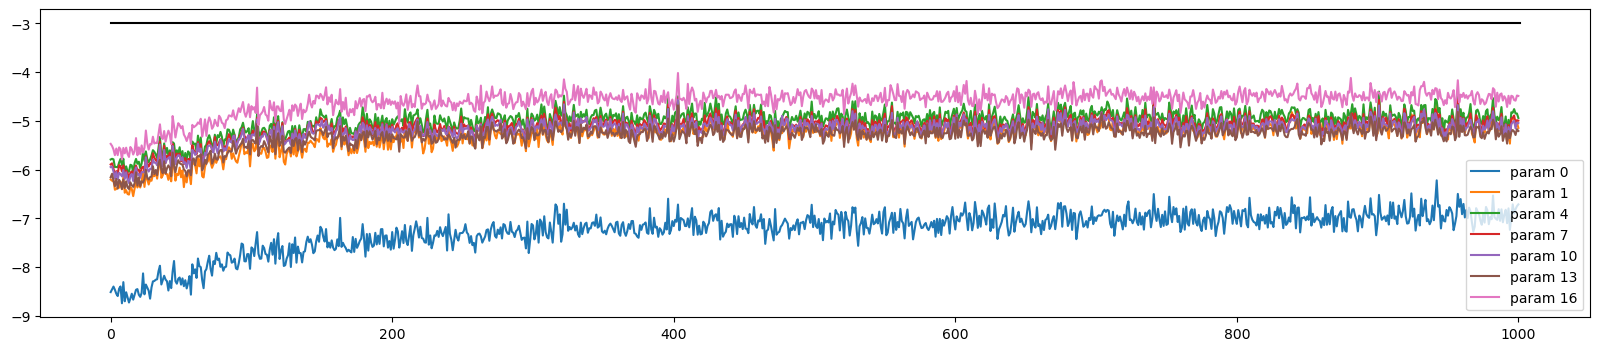

In [50]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.data.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);